In [1]:
import kagglehub
dataset_path = kagglehub.dataset_download('weiming97/hrsc2016-ms-dataset')


In [15]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import numpy as np
from torchvision.transforms.functional import to_tensor

class HRSC2016Dataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.image_dir = os.path.join(dataset_path, 'AllImages')
        self.annotation_dir = os.path.join(dataset_path, 'Annotations')
        self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.bmp')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)


        image = Image.open(image_path).convert("RGB")
        original_size = image.size


        annotation_file = image_file.replace('.bmp', '.xml')
        annotation_path = os.path.join(self.annotation_dir, annotation_file)
        boxes = self.parse_annotation(annotation_path)


        boxes = self.convert_to_midpoint_offset(boxes, original_size)

        if self.transform:
            image = self.transform(image)
        new_size = (256, 256)  # Width, Height
        image = image.resize(new_size, Image.BILINEAR)
        image = to_tensor(image)
        return image, boxes

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        boxes = []
        for obj in root.iter('object'):
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        return np.array(boxes)

    def convert_to_midpoint_offset(self, boxes, original_size):
        if boxes.size == 0:
            return np.empty((0, 4))

        if boxes.ndim == 1:
            boxes = boxes.reshape(1, 4)

        scale_x = 256 / original_size[0]
        scale_y = 256 / original_size[1]
        # Adjust bounding boxes
        boxes[:, 0] = boxes[:, 0] * scale_x
        boxes[:, 1] = boxes[:, 1] * scale_y
        boxes[:, 2] = boxes[:, 2] * scale_x
        boxes[:, 3] = boxes[:, 3] * scale_y
        midpoints = (boxes[:, :2] + boxes[:, 2:]) / 2
        offsets = (boxes[:, 2:] - boxes[:, :2]) / 2
        return np.concatenate([midpoints, offsets], axis=1)


dataset = HRSC2016Dataset(dataset_path)


[[ 86.   41.5  14.   33.5]
 [ 83.  111.   17.    7. ]
 [ 53.  195.5  17.    5.5]
 [ 51.5 205.   17.5   6. ]
 [ 48.  219.5   6.    2.5]
 [ 47.  224.    6.    2. ]
 [ 64.5 221.5   6.5   2.5]
 [ 61.  225.5   7.    2.5]
 [ 85.  224.5   7.    2.5]
 [ 92.   49.5  11.   29.5]
 [ 98.   51.   11.   30. ]
 [105.5  51.5  10.5  29.5]
 [134.  123.   21.    8. ]
 [131.5 140.5  21.5   7.5]
 [ 68.  134.5   1.    3.5]
 [104.  210.   23.    7. ]
 [211.5 217.    1.5   2. ]
 [222.5 215.5   7.5   5.5]]


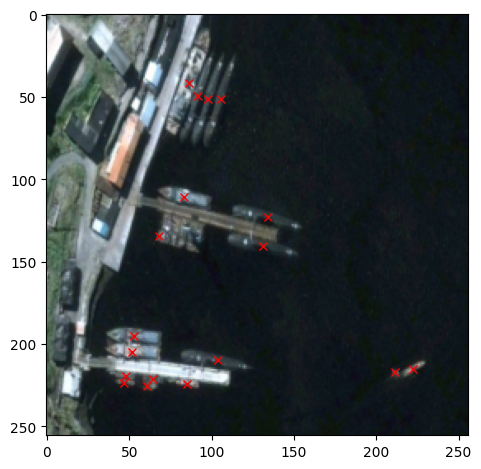

In [4]:
import matplotlib.pyplot as plt

def show_sample(file):
    image, boxes = file

    image = image.cpu()
    print(boxes)

    img = image.permute(1, 2, 0).numpy()
    plt.imshow(img)


    for box in boxes:
        x_center, y_center, w_offset, h_offset = box
        plt.plot(x_center, y_center, 'rx')  # red cross at center

    plt.tight_layout()
    plt.show()

show_sample(dataset[61])

In [5]:
import random

n = int(0.2 * len(dataset))
x = len(dataset)
random_numbers = random.sample(range(x), n)

random_numbers_set = set(random_numbers)


In [6]:

# Split the dataset into training and testing sets
train_files = [dataset[i] for i in range(len(dataset)) if i not in random_numbers_set]
test_files = [dataset[i] for i in range(len(dataset)) if i in random_numbers_set]


print(len(train_files), len(test_files))

1344 336


In [7]:
def collate_fn(batch):
    images = []
    targets = []
    for b in batch:
        images.append(b[0])
        targets.append(torch.tensor(b[1], dtype=torch.float32))
    return torch.stack(images), targets


[[130.5 148.5  47.5  51.5]]


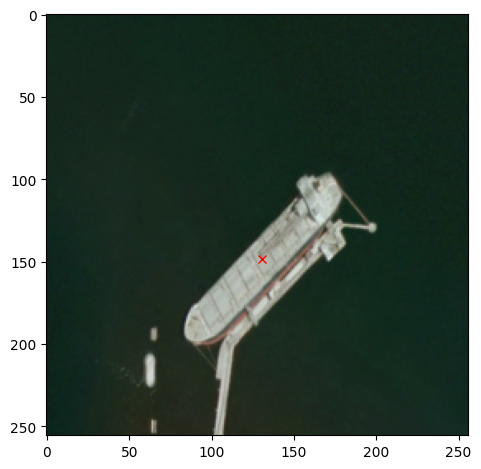

In [ ]:
show_sample(test_files[100])

Epoch 1/36


100%|██████████| 168/168 [00:27<00:00,  6.04it/s]


Loss: 0.0225
Epoch 2/36


100%|██████████| 168/168 [00:27<00:00,  6.08it/s]


Loss: 0.0040
Epoch 3/36


100%|██████████| 168/168 [00:26<00:00,  6.23it/s]


Loss: 0.0029
Epoch 4/36


100%|██████████| 168/168 [00:27<00:00,  6.18it/s]


Loss: 0.0025
Epoch 5/36


100%|██████████| 168/168 [00:27<00:00,  6.12it/s]


Loss: 0.0025
Epoch 6/36


100%|██████████| 168/168 [00:27<00:00,  6.17it/s]


Loss: 0.0020
Epoch 7/36


100%|██████████| 168/168 [00:27<00:00,  6.20it/s]


Loss: 0.0018
Epoch 8/36


100%|██████████| 168/168 [00:27<00:00,  6.12it/s]


Loss: 0.0017
Epoch 9/36


100%|██████████| 168/168 [00:27<00:00,  6.14it/s]


Loss: 0.0014
Epoch 10/36


100%|██████████| 168/168 [00:27<00:00,  6.13it/s]


Loss: 0.0012
Epoch 11/36


100%|██████████| 168/168 [00:27<00:00,  6.17it/s]


Loss: 0.0013
Epoch 12/36


100%|██████████| 168/168 [00:27<00:00,  6.19it/s]


Loss: 0.0010
Epoch 13/36


100%|██████████| 168/168 [00:27<00:00,  6.15it/s]


Loss: 0.0007
Epoch 14/36


100%|██████████| 168/168 [00:27<00:00,  6.12it/s]


Loss: 0.0007
Epoch 15/36


100%|██████████| 168/168 [00:27<00:00,  6.20it/s]


Loss: 0.0007
Epoch 16/36


100%|██████████| 168/168 [00:27<00:00,  6.22it/s]


Loss: 0.0007
Epoch 17/36


100%|██████████| 168/168 [00:27<00:00,  6.21it/s]


Loss: 0.0007
Epoch 18/36


100%|██████████| 168/168 [00:27<00:00,  6.19it/s]


Loss: 0.0007
Epoch 19/36


100%|██████████| 168/168 [00:27<00:00,  6.18it/s]


Loss: 0.0007
Epoch 20/36


100%|██████████| 168/168 [00:27<00:00,  6.19it/s]


Loss: 0.0006
Epoch 21/36


100%|██████████| 168/168 [00:27<00:00,  6.18it/s]


Loss: 0.0006
Epoch 22/36


100%|██████████| 168/168 [00:27<00:00,  6.17it/s]


Loss: 0.0006
Epoch 23/36


100%|██████████| 168/168 [00:27<00:00,  6.18it/s]


Loss: 0.0006
Epoch 24/36


100%|██████████| 168/168 [00:27<00:00,  6.20it/s]


Loss: 0.0006
Epoch 25/36


100%|██████████| 168/168 [00:27<00:00,  6.19it/s]


Loss: 0.0006
Epoch 26/36


100%|██████████| 168/168 [00:27<00:00,  6.17it/s]


Loss: 0.0006
Epoch 27/36


100%|██████████| 168/168 [00:27<00:00,  6.15it/s]


Loss: 0.0006
Epoch 28/36


100%|██████████| 168/168 [00:27<00:00,  6.20it/s]


Loss: 0.0005
Epoch 29/36


100%|██████████| 168/168 [00:27<00:00,  6.19it/s]


Loss: 0.0006
Epoch 30/36


100%|██████████| 168/168 [00:27<00:00,  6.18it/s]


Loss: 0.0006
Epoch 31/36


100%|██████████| 168/168 [00:27<00:00,  6.13it/s]


Loss: 0.0006
Epoch 32/36


100%|██████████| 168/168 [00:27<00:00,  6.19it/s]


Loss: 0.0006
Epoch 33/36


100%|██████████| 168/168 [00:27<00:00,  6.20it/s]


Loss: 0.0005
Epoch 34/36


100%|██████████| 168/168 [00:27<00:00,  6.20it/s]


Loss: 0.0006
Epoch 35/36


100%|██████████| 168/168 [00:27<00:00,  6.18it/s]


Loss: 0.0005
Epoch 36/36


100%|██████████| 168/168 [00:27<00:00,  6.20it/s]


Loss: 0.0005


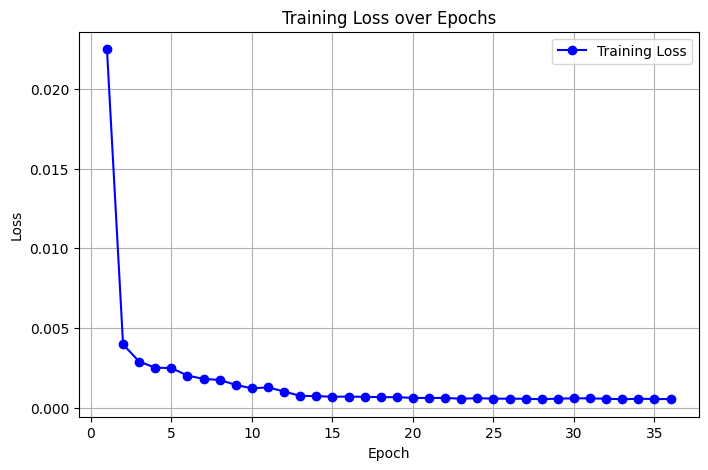

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as T
from torchvision.ops import FeaturePyramidNetwork
from torchvision.ops.feature_pyramid_network import LastLevelMaxPool
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==================== Augmentation ====================
def get_transform(train=True):
    if train:
        return A.Compose([
            A.Resize(256, 256),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=10, p=0.3, border_mode=0),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(256, 256),
            ToTensorV2()
        ])

# ==================== Custom Model ====================
class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_classes=1):
        super(DetectionHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, 256, 3, padding=1)
        self.cls_head = nn.Conv2d(256, num_classes, 1)
        self.reg_head = nn.Conv2d(256, 5, 1)

    def forward(self, x):
        x = self.conv(x)
        cls_logits = self.cls_head(x)
        reg = self.reg_head(x)
        return cls_logits, reg


class CNNROriented(nn.Module):
    def __init__(self, num_classes=1):
        super(CNNROriented, self).__init__()
        backbone = models.resnet50(pretrained=True)
        self.body = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
        )
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 2048],
            out_channels=256,
            extra_blocks=LastLevelMaxPool()
        )
        self.head = DetectionHead(256, num_classes)

    def forward(self, x):
        c1 = self.body[4](self.body[3](self.body[2](self.body[1](self.body[0](x)))))
        c2 = self.body[5](c1)
        c3 = self.body[6](c2)
        c4 = self.body[7](c3)

        features = self.fpn({"0": c1, "1": c2, "2": c3, "3": c4})
        out = self.head(features["0"])
        return out

# ==================== Loss Function ====================
def compute_loss(pred_cls, pred_reg, targets):
    cls_loss = nn.BCEWithLogitsLoss()
    reg_loss = nn.SmoothL1Loss()

    cls_targets = torch.ones_like(pred_cls)
    cls_l = cls_loss(pred_cls, cls_targets)

    reg_l = reg_loss(pred_reg, targets)
    return cls_l + reg_l

# ==================== Target Conversion ====================
def format_targets(boxes):

    target_tensor = torch.zeros((5, 16, 16))
    if boxes.size == 0:
        return target_tensor


    for box in boxes:
        cx, cy, w_half, h_half = box[:4]
        w, h = w_half * 2, h_half * 2
        angle = 0
        # Find grid cell
        grid_x = int(cx / 16)
        grid_y = int(cy / 16)
        if grid_x < 16 and grid_y < 16:
            target_tensor[0, grid_y, grid_x] = cx / 256
            target_tensor[1, grid_y, grid_x] = cy / 256
            target_tensor[2, grid_y, grid_x] = w / 256
            target_tensor[3, grid_y, grid_x] = h / 256
            target_tensor[4, grid_y, grid_x] = angle / 180.0  # normalized
    return target_tensor

# ==================== Training ====================
def train(model, dataloader, optimizer, scheduler):
    model.train()

    total_loss = 0
    for imgs, boxes_batch in tqdm(dataloader):
        imgs = imgs.to(device)
        targets = torch.stack([format_targets(boxes) for boxes in boxes_batch]).to(device)

        optimizer.zero_grad()
        pred_cls, pred_reg = model(imgs)


        pred_cls_center = pred_cls[:, :, 8, 8]
        pred_reg_center = pred_reg[:, :, 8, 8]
        target_reg_center = targets[:, :, 8, 8]

        loss = compute_loss(pred_cls_center, pred_reg_center, target_reg_center)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    return total_loss / len(dataloader)

# ==================== Main ====================


train_loader = DataLoader(train_files, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_files, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)


model = CNNROriented(num_classes=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
train_losses = []
num_epochs = 36
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    loss = train(model, train_loader, optimizer, scheduler)
    train_losses.append(loss)
    print(f"Loss: {loss:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import torch
from torchvision.ops import box_iou
import numpy as np

def evaluate_model(model, test_loader, device, iou_threshold=0.5):

    model.eval()
    all_preds = []
    all_gts = []
    all_scores = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = torch.stack([format_targets(boxes) for boxes in targets]).to(device)

            outputs = model(images)
            print(outputs)

            pred_boxes = outputs[0]['boxes']
            pred_labels = outputs[0]['labels']
            pred_scores = outputs[0]['scores']


            gt_boxes = [target['boxes'] for target in targets]
            gt_labels = [target['labels'] for target in targets]


            all_preds.append(pred_boxes.cpu().numpy())
            all_gts.append(gt_boxes)
            all_scores.append(pred_scores.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_scores = np.concatenate(all_scores, axis=0)


    all_iou = box_iou(torch.tensor(all_preds), torch.tensor(all_gts))


    true_positives = 0
    false_positives = 0
    false_negatives = 0


    for i in range(len(all_preds)):

        max_iou, max_iou_index = torch.max(all_iou[i], dim=0)
        if max_iou >= iou_threshold:
            true_positives += 1
        else:
            false_positives += 1


        if max_iou < iou_threshold:
            false_negatives += 1


    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)


    mean_average_precision = (precision + recall) / 2

    return mean_average_precision, precision, recall, all_preds
preds = evaluate_model(model, test_loader, device)


In [ ]:
from shapely.geometry import Polygon

def obb_iou(pred_boxes, gt_boxes):

    ious = []

    for pred, gt in zip(pred_boxes, gt_boxes):
        # Convert (cx, cy, w, h, angle) to polygon for both predicted and ground truth boxes
        pred_polygon = create_rotated_polygon(pred)
        gt_polygon = create_rotated_polygon(gt)

        # Compute IoU using Shapely's intersection and union
        intersection = pred_polygon.intersection(gt_polygon).area
        union = pred_polygon.area + gt_polygon.area - intersection
        iou = intersection / union if union != 0 else 0.0
        ious.append(iou)

    return ious


def create_rotated_polygon(box):

    cx, cy, w, h, angle = box

    half_w, half_h = w / 2, h / 2
    box_points = [
        (-half_w, -half_h),
        (half_w, -half_h),
        (half_w, half_h),
        (-half_w, half_h),
    ]


    rotated_points = []
    for point in box_points:
        x, y = point
        x_rot = cx + x * np.cos(angle) - y * np.sin(angle)
        y_rot = cy + x * np.sin(angle) + y * np.cos(angle)
        rotated_points.append((x_rot, y_rot))

    # Create a Shapely Polygon
    return Polygon(rotated_points)


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import average_precision_score

def evaluate(model, dataloader, device, num_classes=81):
    model.eval()
    all_preds = defaultdict(list)
    all_targets = defaultdict(list)

    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)

            for i, (output, target) in enumerate(zip(outputs, targets)):
                print(f"Output {i} shape: {output.shape}")


                boxes = output[:, :-1].cpu().numpy()
                scores = output[:, -1].cpu().numpy()
                labels = target[:, -1].cpu().numpy()


                for box, score, label in zip(boxes, scores, labels):
                    all_preds[label].append((box, score))


                gt_boxes = target[:, :-1].cpu().numpy()
                gt_labels = target[:, -1].cpu().numpy()

                for box, label in zip(gt_boxes, gt_labels):
                    all_targets[label].append(box)

    # Compute mAP
    mean_ap = compute_map(all_preds, all_targets, num_classes)
    print(f"Mean Average Precision (mAP): {mean_ap:.4f}")


def compute_map(all_preds, all_targets, num_classes):


    aps = []

    for label in range(1, num_classes):
        preds = all_preds[label]
        targets = all_targets[label]


        if len(preds) == 0 or len(targets) == 0:
            continue

        pred_boxes = np.array([p[0] for p in preds])
        pred_scores = np.array([p[1] for p in preds])
        gt_boxes = np.array(targets)

        ious = np.array([obb_iou(pred_boxes, gt_boxes)])


        sorted_idx = np.argsort(pred_scores)[::-1]
        sorted_preds = pred_boxes[sorted_idx]
        sorted_scores = pred_scores[sorted_idx]
        sorted_ious = ious[sorted_idx]


        tp = np.zeros(len(sorted_preds))
        fp = np.zeros(len(sorted_preds))


        for i, iou in enumerate(sorted_ious):
            if iou > 0.5:
                tp[i] = 1
            else:
                fp[i] = 1

        ap = average_precision_score(tp, fp)
        aps.append(ap)

    return np.mean(aps)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate(model, test_loader, device)

In [ ]:
def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1)

    if mode == 'a2p':
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor

    proj_bboxes.masked_fill_(invalid_bbox_mask, -1)
    proj_bboxes.resize_as_(bboxes)

    return proj_bboxes
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)



def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)



def center(out_size):
    out_h, out_w = out_size

    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5

    return anc_pts_x, anc_pts_y


def generate_proposals(anchors, offsets):

    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]

    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale

                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)

    return anc_base

def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):

    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
    tot_anc_boxes = anc_boxes_flat.size(dim=1)

    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1)))

    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)

    return ious_mat

def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1]

    tot_anc_boxes = A * w_amap * h_amap


    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)


    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)


    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0)
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)

    positive_anc_ind_sep = torch.where(positive_anc_mask)[0]
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]


    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)

    GT_conf_scores = max_iou_per_anc[positive_anc_ind]


    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]


    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]

    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2)
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]

    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)


    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]

    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep


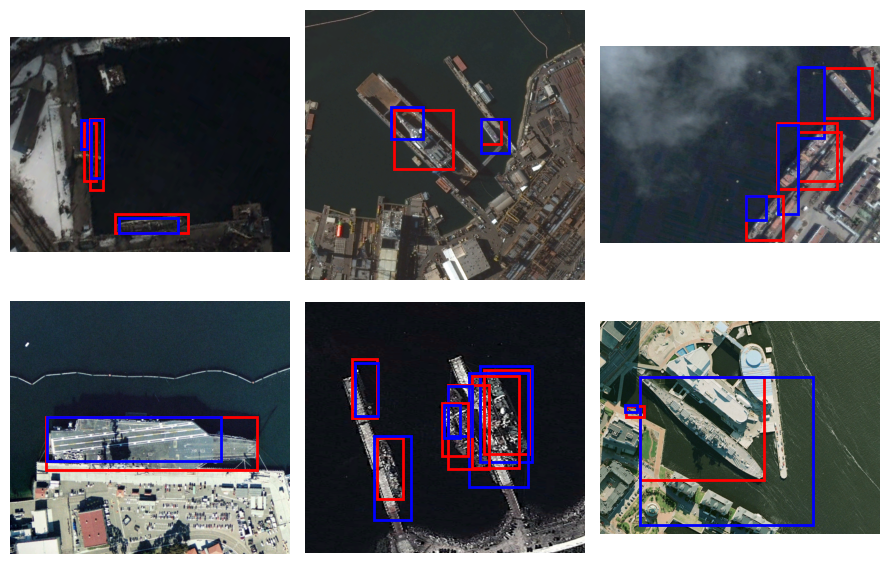

In [19]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
import xml.etree.ElementTree as ET


def show_images_with_boxes(image_boxes_list, pred_img_box, cols=3):

    rows = (len(image_boxes_list) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axs = axs.flatten()

    for i, (img, boxes) in enumerate(image_boxes_list):
        w, h = img.shape[1], img.shape[2]
        img = transforms.ToPILImage()(img) if isinstance(img, torch.Tensor) else img

        axs[i].imshow(img)
        axs[i].axis('off')
        ax = axs[i]

        for j, box in enumerate(boxes):
            x_min, y_min, x_max, y_max = box
            x_min2, y_min2, x_max2, y_max2 = pred_img_box[i][j][0], pred_img_box[i][j][1], pred_img_box[i][j][2], pred_img_box[i][j][3]
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            rect2 = patches.Rectangle((x_min2, y_min2), x_max2 - x_min2, y_max2 - y_min2,
                                     linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect2)

    # Hide any remaining axes
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

lst = [test_loader[1], test_loader[2], test_loader[3], test_loader[4], test_loader[5], test_loader[6]]

show_images_with_boxes(lst, all_preds[1:7])